In [32]:
%matplotlib inline
import chainer
from chainer import optimizers, cuda, serializers
import chainer.functions as F
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
import time
import datetime
from net import Net, MLP

In [33]:
n_epoch = 3000000 #エポック
batchsize = 5000 #バッチサイズ
printout_interval = 100000 #何エポック毎に誤差をプリントアウトするか

bprop_len = 100 #何回でバックプロパゲーションを打ち切るか(trancate)
n_units = 20 #中間層のユニット数
grad_clip = 5 #誤差関数の絶対値をこの値に制限する
use_gpu = True #GPUを使うかどうか

In [34]:
xp = cuda.cupy if use_gpu is True else np

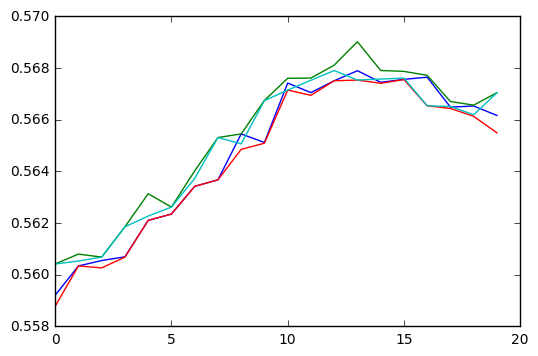

In [35]:
raw_data = []
f = open('nikkei5min.csv','r')
data = csv.reader(f, delimiter=',')
for row in data:
    if row[7] == "":
        continue
    raw_data.append([row[2], row[3], row[4], row[5]])
raw_data = np.asarray(raw_data, dtype=np.float32)
raw_data = raw_data / 20000
data_x = raw_data[:-1]
data_y = raw_data[1:]
train_data_x, test_data_x = data_x[:int(len(data_x) * 0.8)], data_x[:int(len(data_x) * 0.2)]
train_data_y, test_data_y = data_y[:int(len(data_y) * 0.8)], data_y[:int(len(data_y) * 0.2)]

#plt.plot(train_data_x[:20])
plt.plot(train_data_y[:20])

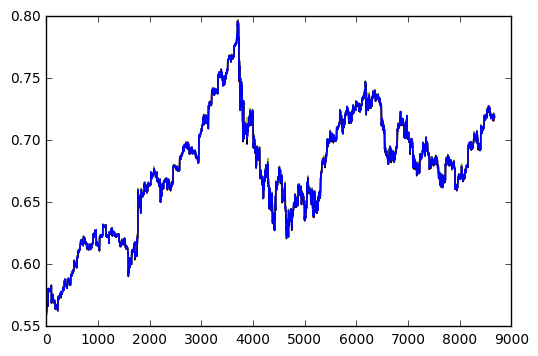

In [36]:
plt.plot(test_data_x)
plt.plot(test_data_y)

In [37]:
#ネットワークを試す関数
def evaluate(model, x, y):
    evaluator = model.copy()
    evaluator.reset_state()
    out = evaluator.predict(x)
    error = F.mean_squared_error(out, y)
    return chainer.cuda.to_cpu(out.data), error.data

In [38]:
model = Net(4, n_units, 4)#入力の次元数, 中間層の次元数
if use_gpu is True:
    model.to_gpu()
optimizer = optimizers.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(grad_clip))
loss = []
test_loss = []
length = len(train_data_x)
jump = length // batchsize
batch_idxs = list(range(batchsize))
accum_loss = 0
epoch = 0
loss_data = 0
x_cache = []
y_cache = []
x_chainer_variable = chainer.Variable(xp.asarray(train_data_x, dtype=np.float32))
y_chainer_variable = chainer.Variable(xp.asarray(train_data_y, dtype=np.float32))
test_data_x_chainer_variable = chainer.Variable(xp.asarray(test_data_x, dtype=np.float32))
test_data_y_chainer_variable = chainer.Variable(xp.asarray(test_data_y, dtype=np.float32))
prev_time = time.time()
for i in range(jump * n_epoch):
    if len(x_cache) <= i % jump:
        x_cache.append( chainer.Variable(xp.asarray([train_data_x[(jump * j + i) % length] for j in batch_idxs])))
        y_cache.append( chainer.Variable(xp.asarray([train_data_y[(jump * j + i) % length] for j in batch_idxs])))
    x = x_cache[i % jump]
    y = y_cache[i % jump]
    #x = chainer.Variable(xp.asarray([[train_data_x[(jump * j + i) % length]] for j in batch_idxs]))
    #y = chainer.Variable(xp.asarray([[train_data_y[(jump * j + i) % length]] for j in batch_idxs]))
    loss_i = model(x,y)
    accum_loss += loss_i
    loss_data += accum_loss.data
        
    if (i+1) % jump == 0:
        epoch += 1
        if epoch % printout_interval == 0:
            now = time.time()
            elapsed_time = now - prev_time
            prev_time = now
            speed = printout_interval / elapsed_time
            eta = datetime.timedelta(seconds = (n_epoch - epoch) / speed)
            eta = datetime.timedelta(seconds = eta.seconds)
            print('epoch {0}, error {1}, {2:.2f} epoch/s, eta {3}'.format(epoch, loss_data * len(x) / length, speed, eta))
        loss.append(evaluate(model, x_chainer_variable, y_chainer_variable)[1])
        test_loss.append(evaluate(model, test_data_x_chainer_variable, test_data_y_chainer_variable)[1])
        loss_data = 0
        model.reset_state()
        
    
    if (i+1) % bprop_len == 0:
        model.zerograds()
        accum_loss.backward()
        accum_loss.unchain_backward()
        accum_loss = 0
        optimizer.update()

epoch 100000, error 0.000687349122017622, 64.62 epoch/s, eta 12:27:55
epoch 200000, error 0.000573101220652461, 64.74 epoch/s, eta 12:00:47
epoch 300000, error 0.0005407336284406483, 65.08 epoch/s, eta 11:31:29
epoch 400000, error 0.00048026020522229373, 64.85 epoch/s, eta 11:08:10
epoch 500000, error 0.0013810680247843266, 64.96 epoch/s, eta 10:41:23
epoch 600000, error 0.000462124909972772, 64.86 epoch/s, eta 10:16:40
epoch 700000, error 0.0026129158213734627, 64.63 epoch/s, eta 9:53:09
epoch 800000, error 0.000664682884234935, 65.06 epoch/s, eta 9:23:36
epoch 900000, error 0.0004499140486586839, 64.81 epoch/s, eta 8:59:59
epoch 1000000, error 0.00044809389510191977, 64.74 epoch/s, eta 8:34:53
epoch 1100000, error 0.0009854197269305587, 65.01 epoch/s, eta 8:07:07
epoch 1200000, error 0.0004418209136929363, 64.80 epoch/s, eta 7:42:58
epoch 1300000, error 0.0004398369637783617, 64.63 epoch/s, eta 7:18:24
epoch 1400000, error 0.00043794134398922324, 64.87 epoch/s, eta 6:51:05
epoch 1500

In [39]:
#モデルを保存
serializers.save_npz('my.model', model)

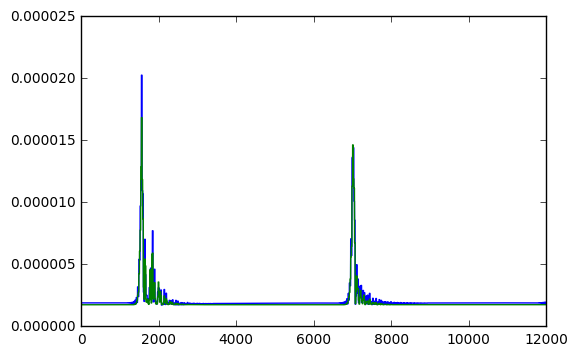

In [40]:
plt.plot(loss[-12000:])
plt.plot(test_loss[-12000:])

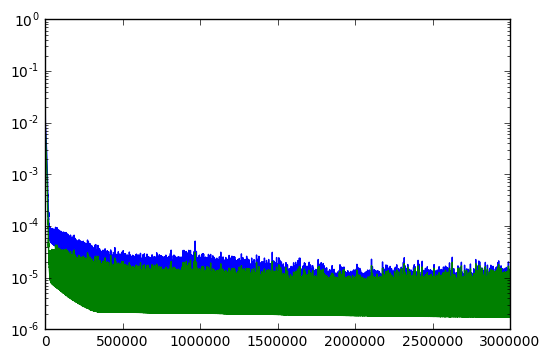

In [41]:
plt.plot(loss)
plt.plot(test_loss)
plt.yscale('log')

In [42]:
output, error = evaluate(model, x_chainer_variable, y_chainer_variable)

print(error)

2.004478801609366e-06


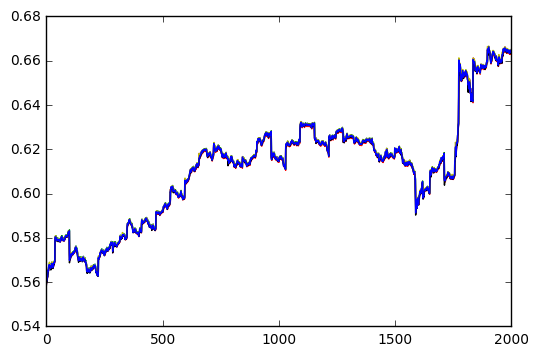

In [43]:
plt.plot(output[:2000])
plt.plot(train_data_y[:2000])

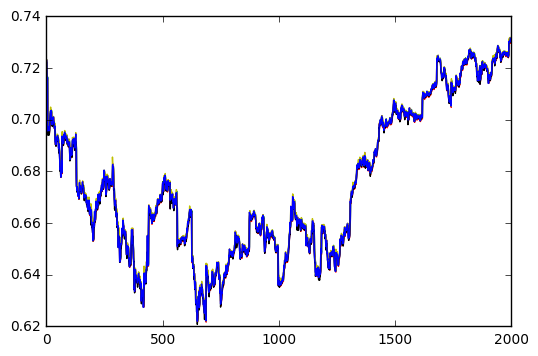

In [44]:
plt.plot(output[4000:6000])
plt.plot(train_data_y[4000:6000])

In [45]:
output, error = evaluate(model, test_data_x_chainer_variable, test_data_y_chainer_variable)
print('test error = {}'.format(error))

test error = 1.7724231611282448e-06


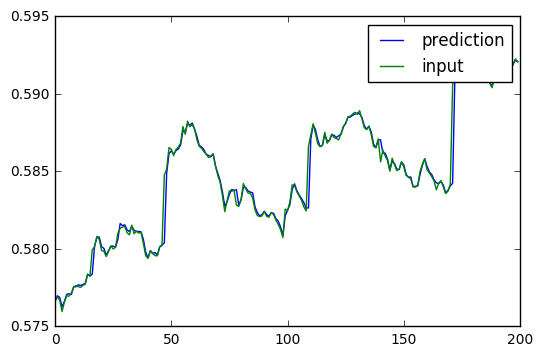

In [46]:
plt.plot(output[300:500, 0], label='prediction')
plt.plot(test_data_y[300:500, 0], label='input')
plt.legend()